In [ ]:
#Importo il modulo drive, fornito da Colab, per interagire con Google Drive.
from google.colab import drive
#Monta il mio Google Drive nella directory locale /content/drive del runtime, con la garanzia che sia in uno stato "pulito".
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
global_var = {
    # PARAMETRI DI CARICAMENTO / PREPROCESSING DEI DATI:
    "batch_size": 192,          #Dimensione batch (A100 regge 192 a seq_len=1024).
    "n_workers": 8,             #Processi del DataLoader per pre-caricare i batch (I/O più fluido).
    "max_seq_len": 1024,        #Lunghezza massima in token: troncamento/padding a 1024.

    # PARAMETRI DEL MODELLO (Transformer):
    "embedding_dim": 256,       #Dimensione degli embedding e dei canali del Transformer.
    "n_layers": 6,              #Numero di blocchi Transformer (profondità del modello).
    "n_heads": 8,               #Teste di attenzione --> 256/8=32 dim per head.
    "ff_dim": 1024,             #Dim del feed-forward interno.
    "dropout": 0.10,            #Dropout moderato (dataset ampio; regolarizzazione senza underfit).
    "output_dim": 2,            #Numero classi: 0=HUMAN, 1=GenAI (logits K=2).

    # PARAMETRI DI TRAINING:
    "learning_rate": 2e-4,      #LR base (pensato per scheduler con warmup).
    "epochs": 8,                #Epoche massime di addestramento.
    "weight_decay": 0.01,       #Regolarizzazione L2 in AdamW (decoupled weight decay).
    "label_smoothing": 0.05,    #Smussamento etichette (migliora calibrazione/confidenza).
    "grad_clip": 1.0,           #Clipping L2 della norma del gradiente (stabilità).

    # PARAMETRI DI VALIDAZIONE/REGOLARIZZAZIONE (per early stopping):
    "val_size": 0.2,            #Frazione del train riservata alla validation (20%).
    "patience": 4,              #Early stopping: stop se non vi è nessun miglioramento per 4 epoche.
    "min_delta": 1e-4,          #Miglioramento minimo richiesto su val-loss per azzerare la pazienza.

    # PARAMETRI PER LO SCHEDULER (warmup e cosine):
    "warmup_ratio": 0.06,       #Percentuale di step totali in warmup (~6%), prima del decadimento coseno.
}

In [ ]:
# Deve stare PRIMA di qualunque import di torch / modello / training
import os
os.environ["TORCHINDUCTOR_CUDAGRAPHS"] = "0"
os.environ["TORCH_USE_CUDAGRAPHS"] = "0"     # doppia cintura
# opzionale: niente ricompile caching aggressivo
os.environ["TORCH_COMPILE_DEBUG"] = "0"

print("[BOOT] CUDAGraphs disabilitati per TorchInductor.")

[BOOT] CUDAGraphs disabilitati per TorchInductor.


In [ ]:
# STANDARD LIBRARY (Python):
import os                        #Gestione percorsi, variabili d'ambiente, I/O di base.
import math                      #Funzioni matematiche (p.es. ceil, log, sqrt).
import copy                      #Copie profonde/superficiali di oggetti complessi (es. pesi modello).
import re                        #Espressioni regolari per pulizia e parsing dei testi.
import random                    #RNG standard (per seed e sampling semplice).
from collections import Counter  #Conteggi frequenze di token/etichette.

# CALCOLO NUMERICO / DATI TABELLARI:
import numpy as np               #Tensori/array N-dim, operazioni numeriche vettorizzate.
import pandas as pd              #Tabelle, CSV/Parquet, join/filter/groupby.

# VISUALIZZAZIONE:
import matplotlib.pyplot as plt  #Grafici 2D (linee, barre, scatter, heatmap via imshow).
import seaborn as sns            #Wrapper statistico su Matplotlib (stile + funzioni comode).

# PROGRESS BAR (notebook-friendly):
from tqdm.notebook import tqdm   #Barra di avanzamento per loop su batch/epoche.

# PyTorch (core + dataset + mixed precision):
import torch                                              #Tensori e operazioni su CPU/GPU; gestione device.
import torch.nn as nn                                     #Moduli di rete (Linear, Dropout, ReLU, etc).
import torch.nn.functional as F                           #Funzioni funzionali (relu, cross_entropy, log_softmax, etc).
from torch.utils.data import Dataset, DataLoader, Subset  #API per dataset custom e mini-batch.
from torch.cuda import amp                                #Per AMP.
from torch.cuda.amp import autocast, GradScaler           #AMP: mixed precision e scaler.

# Scikit-learn (split + metriche):
from sklearn.model_selection import train_test_split      #Split train/val/test stratificato.
from sklearn.metrics import (
    accuracy_score,                                       #Accuratezza: (TP+TN)/totale;
    balanced_accuracy_score,                              #Media delle recall per classe;
    f1_score,                                             #F1 = 2·(precision·recall)/(precision+recall);
    precision_recall_fscore_support,                      #Precision, recall, fscore per classe e macro/micro;
    confusion_matrix,                                     #Matrice di confusione (TP/TN/FP/FN per classe);
    classification_report                                 #Report testuale riassuntivo per classe e aggregati.
)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"[LOG] Device → {device}")

if device.type == "cuda":
    name = torch.cuda.get_device_name(0)
    cap  = torch.cuda.get_device_capability(0)
    print(f"[LOG] CUDA device → {name}, compute capability={cap}")

    # TF32 per matmul (A100)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.set_float32_matmul_precision('high')

    # Forza SDPA --> FlashAttention quando possibile
    try:
        # Use the new API if available
        from torch.nn.attention import sdpa_kernel
        torch.backends.cuda.enable_flash_sdp(True)
        torch.backends.cuda.enable_math_sdp(False)
        torch.backends.cuda.enable_mem_efficient_sdp(True)
    except ImportError:
        # Fallback to the old API if the new one is not available
        torch.backends.cuda.sdp_kernel(enable_flash=True, enable_math=False, enable_mem_efficient=True)


    # Usa BF16 su A100 (altrimenti FP16)
    BF16_OK = hasattr(torch.cuda, "is_bf16_supported") and torch.cuda.is_bf16_supported()
    AMP_DTYPE = torch.bfloat16 if (cap[0] >= 8 and BF16_OK) else torch.float16
    USE_BF16  = (AMP_DTYPE == torch.bfloat16)
else:
    AMP_DTYPE = torch.float32
    USE_BF16  = False

[LOG] Device → cuda:0
[LOG] CUDA device → NVIDIA A100-SXM4-80GB, compute capability=(8, 0)


In [ ]:
def collate_trim(batch):
    """
    Collate function per DataLoader.
    Input: batch = lista di tuple (x, y), con x tensore 1D di token ID (padded con 0) e y etichetta.
    Output: (xs_trim, ys) con xs_trim di shape [B, L_batch] dove L_batch = max lunghezza reale nel batch.
    Assunzione: PAD == 0 e non viene usato come token "valido".
    """
    xs, ys = zip(*batch)  #Unpack: xs = sequenze, ys = etichette; xs è una tupla di tensori 1D [T_max].

    #Lunghezza reale per sequenza: conta i token != 0 (cioè non PAD).
    lens = [int((x != 0).sum().item()) for x in xs]

    #Evita edge case L_batch = 0 se tutte le sequenze sono vuote; garantisce almeno 1.
    maxlen = max(1, max(lens)) if lens else 1

    #Taglia ogni sequenza alla lunghezza massima del batch: riduce compute/memoria.
    xs_trim = torch.stack([x[:maxlen] for x in xs])  # Shape [B, maxlen]

    #Stack delle etichette in un tensore 1D di shape [B]
    ys = torch.stack(ys)

    return xs_trim, ys

def make_loader(dataset, batch_size, shuffle):
    """
    Costruisce un DataLoader "veloce":
      - usa collate_trim per dynamic padding/trimming per-batch;
      - pin_memory su CUDA per velocizzare i transfer CPU→GPU (.to(device, non_blocking=True));
      - se n_workers > 0: worker persistenti + prefetch di più batch.
    """
    kwargs = {}
    if global_var["n_workers"] > 0:
        kwargs["persistent_workers"] = True   #Evita teardown/respawn dei worker ad ogni epoca.
        kwargs["prefetch_factor"] = 6        #Ogni worker pre-carica N batch (default=2); 6 = più aggressivo su A100.
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=global_var["n_workers"],
        pin_memory=(device.type == "cuda"),   #Consigliato su CUDA; innocuo su CPU.
        collate_fn=collate_trim,              #Applica il trimming dinamico definito sopra.
        **kwargs
    )

In [ ]:
BASE = "/content/drive/MyDrive/TESI-Classificazione/MIO"
TRAIN_CSV = f"{BASE}/en_train_full.csv"     # usato per training + vocab
DEV_CSV   = f"{BASE}/en_dev_full.csv"

VAL_CSV   = f"{BASE}/en_val_holdout.csv"    # validation dopo il training
TEST_CSV  = f"{BASE}/en_test_fixed.csv"     # test SOLO per predizioni finali

import pandas as pd, numpy as np, os
df_train = pd.read_csv(TRAIN_CSV)
df_dev   = pd.read_csv(DEV_CSV)

# 60 ID per il TEST (quelli che hai dato tu)
TEST_IDS = [
  1785,6558,6958,7814,8393,22792,24314,24563,25355,26795,26870,29186,36581,40760,
  41855,52126,56445,57316,57790,58514,60992,64197,69344,72099,72844,72926,88238,
  89196,90169,94106,99598,109977,110606,110787,117759,132477,142851,142966,147127,
  154474,154796,157817,158265,167622,170365,177393,183015,183849,187702,193068,
  194164,194395,198917,200148,211244,212189,222169,227883,233881,250929
]
TEST_IDS = list(dict.fromkeys(TEST_IDS))  # de-dup

def pick_test_rows_from_dev(df_dev, ids):
    # 1) prova per colonna 'id' (anche numericizzata)
    if "id" in df_dev.columns:
        m = df_dev["id"].isin(ids)
        if m.sum() < len(ids):
            try:
                m = m | pd.to_numeric(df_dev["id"], errors="coerce").isin(ids)
            except Exception:
                pass
        if int(m.sum()) > 0:
            return df_dev.loc[m].copy(), df_dev.index[m], "by id"

    # 2) fallback: posizioni 0-based vs 1-based
    m0 = df_dev.index.isin(ids)
    m1 = df_dev.index.isin([i-1 for i in ids])
    if int(m0.sum()) >= int(m1.sum()):
        return df_dev.loc[m0].copy(), df_dev.index[m0], "by 0-based row index"
    else:
        return df_dev.loc[m1].copy(), df_dev.index[m1], "by 1-based row index (id-1)"

df_test_sel, used_idx, how = pick_test_rows_from_dev(df_dev, TEST_IDS)
assert len(df_test_sel) > 0, "Nessuna riga selezionata per il TEST (controlla gli ID)."

df_test = df_test_sel.reset_index(drop=True)
df_val  = df_dev.drop(index=used_idx).reset_index(drop=True)

df_val.to_csv(VAL_CSV,  index=False)
df_test.to_csv(TEST_CSV, index=False)
print(f"[LOG] DEV={len(df_dev)} | TEST={len(df_test)} | VAL={len(df_val)}  [{how}]")

[LOG] DEV=261849 | TEST=60 | VAL=261789  [by 0-based row index]


In [ ]:
PAD, UNK, CLS = "<pad>", "<unk>", "<cls>"               #Token speciali riservati: padding (<pad>), fuori-vocabolario (<unk), inizio-sequenza (<cls>).
_token_re = re.compile(r"\b\w+\b", flags=re.UNICODE)    #Regex: cattura sequenze alfanumeriche (token).

def basic_tokenizer(text: str):
    return _token_re.findall(text.lower())            #Tokenizza testo lowercased --> lista di token.

def build_vocab(text_iter, min_freq: int = 1):
    counter = Counter()                               #Contatore di frequenze.
    for line in text_iter:                            #Itera sulle frasi del dataset.
        counter.update(basic_tokenizer(line))         #Aggiorna conteggio token.
    vocab = {PAD:0, UNK:1, CLS:2}                     #Inizializza vocabolario con ID riservati.
    for tok, c in counter.most_common():              #Ordina token per frequenza.
        if c >= min_freq and tok not in vocab:        #Inserisci solo se frequenza >= soglia e non riservato.
            vocab[tok] = len(vocab)                   #Assegna ID progressivo.
    return vocab                                      #Ritorna mapping token-->ID.

class TextDataset(Dataset):
    def __init__(self, csv_path: str, vocab: dict | None = None, preencode: bool = True):
        df = pd.read_csv(csv_path)
        self.texts  = df["text"].astype(str).tolist()
        self.labels = df["label"].astype(int).tolist()
        self.vocab  = vocab or build_vocab(self.texts)

        self.preencode = preencode
        if preencode:
            # Pre-encode una sola volta (veloce alle epoche successive)
            self.x = [self.encode(t) for t in self.texts]
            # lunghezze reali (per bucketing)
            self.lengths = [int((xi != 0).sum().item()) for xi in self.x]
        else:
            self.x = None
            self.lengths = None

    def __len__(self): return len(self.labels)

    def encode(self, text: str):
        toks = basic_tokenizer(text)
        ids = [self.vocab.get(t, self.vocab[UNK]) for t in toks][: max(0, global_var["max_seq_len"]-1)]
        ids = [self.vocab[CLS]] + ids
        pad_len = global_var["max_seq_len"] - len(ids)
        if pad_len > 0:
            ids += [self.vocab[PAD]] * pad_len
        return torch.tensor(ids, dtype=torch.long)

    def __getitem__(self, idx):
        x = self.x[idx] if self.preencode else self.encode(self.texts[idx])
        return x, torch.tensor(self.labels[idx])

In [ ]:
class BucketBatchSampler(torch.utils.data.Sampler):
    def __init__(self, lengths, batch_size, shuffle=True, bucket_size=4096, seed=42):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.rng = np.random.default_rng(seed)

        order = np.argsort(lengths)  # corto→lungo
        # Suddividi in bucket; shuffle dentro il bucket per varietà ma lunghezze simili
        buckets = [order[i:i+bucket_size] for i in range(0, len(order), bucket_size)]
        if shuffle:
            for b in buckets: self.rng.shuffle(b)
            self.rng.shuffle(buckets)
        order = np.concatenate(buckets)

        # Costruisci i batch
        self.batches = [order[i:i+batch_size] for i in range(0, len(order), batch_size)]

    def __iter__(self):
        if self.shuffle:
            self.rng.shuffle(self.batches)
        for b in self.batches:
            yield b.tolist()

    def __len__(self):
        return len(self.batches)

def make_loader(dataset, batch_size, shuffle):
    # worker più alti su A100
    nw = max(4, global_var.get("n_workers", 4))
    kwargs = dict(
        num_workers=nw,
        pin_memory=(device.type == "cuda"),
        pin_memory_device="cuda" if device.type == "cuda" else "",
        persistent_workers=(nw > 0)
    )

    # Se il dataset ha pre-encode + lengths → usa BucketBatchSampler
    if getattr(dataset, "lengths", None) is not None:
        bs = BucketBatchSampler(dataset.lengths, batch_size=batch_size, shuffle=shuffle, bucket_size=batch_size*32)
        return DataLoader(dataset, batch_sampler=bs, collate_fn=collate_trim, prefetch_factor=8, **kwargs)

    # fallback: standard
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_trim,
        prefetch_factor=8,
        **kwargs
    )

In [ ]:
def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

# --- DATASET & DATALOADER ----------------------------------------------------
seed_everything(42)

# vocab SOLO dal TRAIN
train_ds = TextDataset(TRAIN_CSV)       # costruisce il vocab
vocab    = train_ds.vocab

val_ds   = TextDataset(VAL_CSV,  vocab=vocab)   # resto del DEV
test_ds  = TextDataset(TEST_CSV, vocab=vocab)   # 60 righe fisse → predizioni

train_loader = make_loader(train_ds, global_var["batch_size"], shuffle=True)
val_loader   = make_loader(val_ds,  global_var["batch_size"], shuffle=False)
test_loader  = make_loader(test_ds, global_var["batch_size"], shuffle=False)

print("[CHECK] train/val/test =", len(train_ds), len(val_ds), len(test_ds))
assert len(test_ds) == 60, f"TEST deve avere 60 righe, trovato {len(test_ds)}"

[CHECK] train/val/test = 610676 261789 60


In [ ]:
class TransformerTextClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, n_heads, n_layers, ff_dim,
                 out_dim, max_len=1024, p_drop=0.15):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.pos_emb = nn.Embedding(max_len, emb_dim)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim, nhead=n_heads, dim_feedforward=ff_dim,
            dropout=p_drop, activation="gelu", batch_first=True, norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)

        self.drop = nn.Dropout(p_drop)
        self.fc   = nn.Linear(emb_dim * 3, out_dim)

        nn.init.normal_(self.pos_emb.weight, mean=0.0, std=0.02)

    def forward(self, x):
        B, T = x.size()
        pos = torch.arange(T, device=x.device).unsqueeze(0).expand(B, T)
        h = self.tok_emb(x) + self.pos_emb(pos)
        key_padding_mask = (x == 0)
        h = self.encoder(h, src_key_padding_mask=key_padding_mask)
        cls = h[:, 0, :]
        mask = (~key_padding_mask).unsqueeze(-1)
        mean_pool = (h * mask).sum(1) / mask.sum(1).clamp(min=1)
        h_masked = h.masked_fill(key_padding_mask.unsqueeze(-1), float("-inf"))
        max_pool, _ = h_masked.max(dim=1)
        feat = torch.cat([cls, mean_pool, max_pool], dim=1)
        feat = self.drop(feat)
        return self.fc(feat)

model = TransformerTextClassifier(
    vocab_size=len(vocab),
    emb_dim=global_var["embedding_dim"],
    n_heads=global_var["n_heads"],
    n_layers=global_var["n_layers"],
    ff_dim=global_var["ff_dim"],
    out_dim=global_var["output_dim"],
    max_len=global_var["max_seq_len"],
    p_drop=global_var["dropout"]
).to(device)

# (temporaneamente) NIENTE torch.compile per eliminare la causa del crash
print("[LOG] Modello creato (torch.compile DISABILITATO).")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[LOG] Modello creato (torch.compile DISABILITATO).


In [ ]:
# =========[ LOSS / OPT / SCHEDULER / TRAIN ]==================================

# --- Pesi di classe dal TRAIN COMPLETO ---------------------------------------
y_train = np.array(train_ds.labels)
from collections import Counter
cnt = Counter(y_train)
tot = int(sum(cnt.values()))
n0, n1 = int(cnt.get(0, 0)), int(cnt.get(1, 0))

if n0 == 0 or n1 == 0:
    print("[LOG] Una classe è assente → niente class weights")
    class_weights = None
else:
    import numpy as np
    w0, w1 = np.clip([tot / max(1, n0), tot / max(1, n1)], 0.5, 5.0)
    class_weights = torch.tensor([w0, w1], dtype=torch.float, device=device)
    print(f"[LOG] Class weights (clipped): w0={w0:.3f}, w1={w1:.3f}")

loss_fn = nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=global_var["label_smoothing"]
)

adamw_kwargs = dict(lr=global_var["learning_rate"], weight_decay=global_var["weight_decay"])
try:
    optimizer = torch.optim.AdamW(model.parameters(), fused=True, **adamw_kwargs)
except TypeError:
    optimizer = torch.optim.AdamW(model.parameters(), **adamw_kwargs)

steps_per_epoch = max(1, len(train_loader))
total_steps     = steps_per_epoch * global_var["epochs"]
warmup_steps    = max(1, int(global_var["warmup_ratio"] * total_steps))

def lr_lambda(step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    prog = float(step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return max(0.0, 0.5 * (1.0 + math.cos(math.pi * prog)))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# AMP dtype (BF16 su A100; FP16 altrove)
if device.type == "cuda":
    cap_major = torch.cuda.get_device_capability(0)[0]
    bf16_ok   = hasattr(torch.cuda, "is_bf16_supported") and torch.cuda.is_bf16_supported()
    AMP_DTYPE = torch.bfloat16 if (cap_major >= 8 and bf16_ok) else torch.float16
    USE_BF16  = (AMP_DTYPE == torch.bfloat16)
else:
    AMP_DTYPE = torch.float32
    USE_BF16  = False

def train_amp_with_valcurve(model, train_loader, val_loader, epochs):
    """Allena su TRAIN; a fine epoca valuta la VAL (solo logging)."""
    use_cuda   = (device.type == "cuda")
    use_scaler = use_cuda and (not USE_BF16)
    # ✅ API corretta (niente argomento 'cuda' deprecato)
    scaler     = torch.cuda.amp.GradScaler(enabled=use_scaler)

    history = {"train": [], "val": []}

    for ep in range(epochs):
        # -------- TRAIN --------
        model.train()
        running = 0.0
        from tqdm.notebook import tqdm
        pbar = tqdm(train_loader, unit="batch", desc=f"Epoch {ep+1}/{epochs} [train]")

        for bx, by in pbar:
            bx = bx.to(device, non_blocking=True)
            by = by.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            # ✅ autocast corretto: passiamo device_type come stringa e dtype
            with torch.autocast(device_type="cuda", dtype=AMP_DTYPE, enabled=use_cuda):
                logits = model(bx)
                loss   = loss_fn(logits, by)

            if use_scaler:
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), global_var["grad_clip"])
                scaler.step(optimizer); scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), global_var["grad_clip"])
                optimizer.step()

            scheduler.step()

            # ✅ logging senza toccare i grad
            running += loss.detach().item()
            pbar.set_postfix(loss=running/(pbar.n+1), lr=scheduler.get_last_lr()[0])

        train_loss = running / max(1, len(train_loader))
        history["train"].append(train_loss)

        # -------- VAL (solo logging) --------
        model.eval()
        val_running = 0.0
        with torch.inference_mode(), torch.autocast(device_type="cuda", dtype=AMP_DTYPE, enabled=use_cuda):
            for bx, by in val_loader:
                bx = bx.to(device, non_blocking=True)
                by = by.to(device, non_blocking=True)
                vloss = loss_fn(model(bx), by).detach().item()
                val_running += vloss
        val_loss = val_running / max(1, len(val_loader))
        history["val"].append(val_loss)

        print(f"[LOG] Ep{ep+1}: train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

    return history

# --- Avvio training (con curva VAL) ------------------------------------------
history = train_amp_with_valcurve(model, train_loader, val_loader, global_var["epochs"])

[LOG] Class weights (clipped): w0=2.664, w1=1.601


/tmp/ipython-input-2394475225.py:57: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler     = torch.cuda.amp.GradScaler(enabled=use_scaler)


Epoch 1/8 [train]:   0%|          | 0/3181 [00:00<?, ?batch/s]

[LOG] Ep1: train_loss=0.5241 | val_loss=0.4173


Epoch 2/8 [train]:   0%|          | 0/3181 [00:00<?, ?batch/s]

[LOG] Ep2: train_loss=0.3837 | val_loss=0.3481


Epoch 3/8 [train]:   0%|          | 0/3181 [00:00<?, ?batch/s]

[LOG] Ep3: train_loss=0.3338 | val_loss=0.3278


Epoch 4/8 [train]:   0%|          | 0/3181 [00:00<?, ?batch/s]

[LOG] Ep4: train_loss=0.2970 | val_loss=0.2995


Epoch 5/8 [train]:   0%|          | 0/3181 [00:00<?, ?batch/s]

[LOG] Ep5: train_loss=0.2659 | val_loss=0.3022


Epoch 6/8 [train]:   0%|          | 0/3181 [00:00<?, ?batch/s]

[LOG] Ep6: train_loss=0.2391 | val_loss=0.2831


Epoch 7/8 [train]:   0%|          | 0/3181 [00:00<?, ?batch/s]

[LOG] Ep7: train_loss=0.2204 | val_loss=0.2820


Epoch 8/8 [train]:   0%|          | 0/3181 [00:00<?, ?batch/s]

[LOG] Ep8: train_loss=0.2114 | val_loss=0.2840


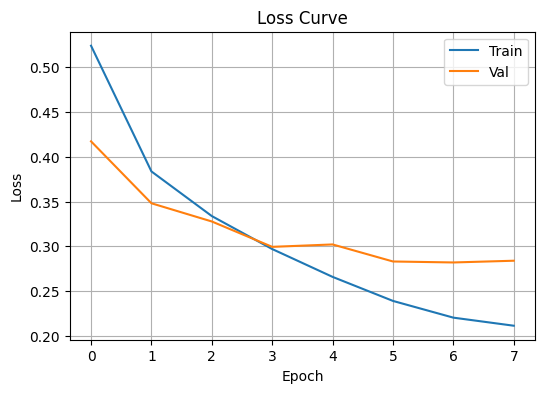

In [ ]:
plt.figure(figsize=(6,4))                                           #Crea una nuova figura 6x4 pollici.
plt.plot(history["train"], label="Train")                           #Traccia la curva della loss di training.
plt.plot(history["val"],   label="Val")                             #Traccia la curva della loss di validazione.
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curve")    #Etichette degli assi X (epoche) e Y (loss) e titolo del grafico.
plt.legend(); plt.grid(True); plt.show()                            #Mostra la legenda (Train/Val), aggiunge la griglia per leggere meglio i valori e renderizza il grafico nella cella.

In [ ]:
# Se serve, si recupera il vocab da oggetti noti.
def extract_vocab(obj):
    seen = set()                                        #Traccia oggetti già visitati per evitare loop.
    while obj is not None and id(obj) not in seen:      #Risali lungo .dataset finché possibile.
        seen.add(id(obj))
        if hasattr(obj, "vocab"):                       #Se l'oggetto espone un attributo 'vocab' --> trovato.
            return obj.vocab
        obj = getattr(obj, "dataset", None)             #Altrimenti prova a risalire a .dataset (DataLoader/Subset).
    return None                                         #Fallback se non trovato.

base_vocab = None
#Si provano candidati globali più probabili (train_dataset --> full_train --> train_loader).
for cand in [globals().get("train_dataset"), globals().get("full_train"), globals().get("train_loader")]:
    if cand is not None:
        base_vocab = extract_vocab(cand)                #Tenta estrazione ricorsiva del vocab.
        if base_vocab is not None: break                #Stop appena trovato.
#Se ancora None, si prova il vocab globale.
if base_vocab is None and "vocab" in globals():
    base_vocab = vocab
#Ultimo fallback: si ricostruisce dal CSV di train (meno ideale ma robusto).
if base_vocab is None:
    base_vocab = TextDataset(TRAIN_CSV).vocab
print(f"[LOG] Vocab OK (size={len(base_vocab):,}).")

def evaluate_loader(model, loader, label_names=("HUMAN","GenAI"),
                    temperature=1.0, threshold=None, plot_cm=False, title_suffix=""):
    model.eval()                                              #Modalità eval (niente dropout/bn).
    y_true, y_pred = [], []
    with torch.inference_mode():                              #Disabilita grad per velocità/memoria.
        for bx, by in loader:
            logits = model(bx.to(device)) / temperature       #Logits scalati con T.
            if threshold is None:                         #Caso 1: decisione argmax (multiclasse).
                pred = logits.argmax(1).cpu().numpy()
            else:                                         #Caso 2: soglia binaria sulla probabilità della classe 1.
                p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
                pred = (p1 >= threshold).astype(int)
            y_pred.extend(pred); y_true.extend(by.cpu().numpy())

    labels_fixed = [0, 1]                                     #Ordine etichette fisso per report/CM.
    report = classification_report(                           #Report strutturato (dict) con metriche per classe e macro.
        y_true, y_pred, labels=labels_fixed,
        target_names=list(label_names),
        output_dict=True, digits=4, zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred, labels=labels_fixed)      #Matrice di confusione.

    if plot_cm:                                         #Visualizzazione opzionale della CM.
        plt.figure(figsize=(5,4))
        tick_labels = [label_names[i] for i in labels_fixed]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=tick_labels, yticklabels=tick_labels, cbar=False)
        ttl = "Confusion Matrix" + (f" {title_suffix}" if title_suffix else "")
        plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(ttl)
        plt.tight_layout(); plt.show()

    return report, cm                                   #Ritorna metriche e CM.

def evaluate_csv(model, csv_path, vocab, batch_size=None, n_workers=None,
                 label_names=("HUMAN","GenAI"), temperature=1.0, threshold=None,
                 plot_cm=False, title_suffix=""):
    batch_size = batch_size or global_var["batch_size"]           #Batch di default da config globale.
    ds = TextDataset(csv_path, vocab=vocab)                       #Dataset dal CSV, forzando il vocab di train.
    dl = make_loader(ds, batch_size=batch_size, shuffle=False)    #DataLoader con dynamic padding.
    rep, cm = evaluate_loader(                                    #Valuta sul loader.
        model, dl, label_names=label_names,
        temperature=temperature, threshold=threshold,
        plot_cm=plot_cm, title_suffix=title_suffix
    )
    return rep, cm, len(ds)                                       #Restituisce anche il numero di esempi.

[LOG] Vocab OK (size=574,882).


[VAL] temperatura ottima T=0.963
[VAL] target=balanced_accuracy → t*=0.425 | bal_acc=0.921 | f1_macro=0.918


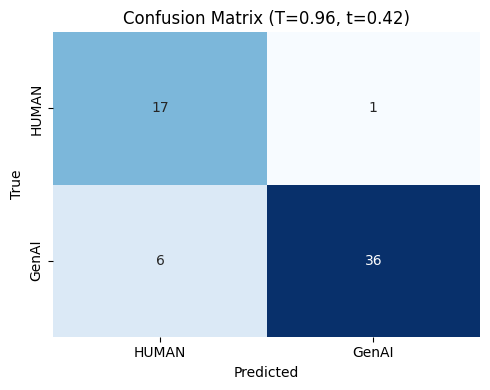


[LOG] Evaluation su TEST — campioni: 60
Accuracy: 0.8833  |  F1 macro: 0.8703  |  Precision macro: 0.8561  |  Recall macro: 0.9008
[LOG] Predizioni TEST (60) salvate in: /content/drive/MyDrive/TESI-Classificazione/MIO/predictions_TEST_en_T0.96_t0.42.csv


In [ ]:
def calibrate_temperature(model, val_loader, device):
    model.eval()                                       #Modalità eval (disattiva dropout/bn).
    logits_list, labels_list = [], []
    with torch.inference_mode():                       #Nessun gradiente durante validazione.
        for bx, by in val_loader:
            logits_list.append(model(bx.to(device)))   #Logits dal modello.
            labels_list.append(by.to(device))          #Label vere.
    logits = torch.cat(logits_list)                    #Concatenazione batch --> [N,K].
    labels = torch.cat(labels_list)                    #Concatenazione label --> [N].

    nll = nn.CrossEntropyLoss()                                   #Funzione obiettivo: NLL.
    logT = torch.tensor(0.0, device=device, requires_grad=True)   #Parametro log(T).
    optT = torch.optim.LBFGS([logT], lr=0.5, max_iter=50)         #Ottimizzatore L-BFGS.

    def closure():                            #Funzione obiettivo per L-BFGS.
        optT.zero_grad()
        T = torch.exp(logT)                   #Temperatura = exp(logT) > 0.
        loss = nll(logits / T, labels)        #NLL con logits scalati.
        loss.backward()
        return loss

    optT.step(closure)                                  #Ottimizzazione T.
    T = torch.exp(logT).item()                          #Temperatura ottimale.
    print(f"[VAL] temperatura ottima T={T:.3f}")
    return T

def tune_threshold_on_val(model, val_loader, device, temperature=1.0,
                          metric="balanced_accuracy", beta=1.1):
    model.eval()
    y_true, y_prob = [], []
    with torch.inference_mode():
        for bx, by in val_loader:
            #Softmax con temperatura --> probabilità classe 1.
            p1 = torch.softmax(model(bx.to(device))/temperature, 1)[:,1].cpu().numpy()
            y_prob.extend(p1); y_true.extend(by.cpu().numpy())
    y_true = np.array(y_true); y_prob = np.array(y_prob)

    #Funzione di scoring in base alla metrica scelta.
    def score(y_hat):
        if metric == "balanced_accuracy":
            return balanced_accuracy_score(y_true, y_hat)
        if metric == "f1_macro":
            return f1_score(y_true, y_hat, average="macro", zero_division=0)
        if metric == "precision_genai":
            p,_r,_f,_s = precision_recall_fscore_support(y_true, y_hat, labels=[0,1], average=None, zero_division=0)
            return p[1]
        if metric == "recall_genai":
            _p,r,_f,_s = precision_recall_fscore_support(y_true, y_hat, labels=[0,1], average=None, zero_division=0)
            return r[1]
        if metric == "fbeta_genai":
            p,r,_f,_s = precision_recall_fscore_support(y_true, y_hat, labels=[0,1], average=None, zero_division=0)
            b2 = beta*beta
            return (1+b2)*p[1]*r[1]/max(1e-12, b2*p[1]+r[1])
        return balanced_accuracy_score(y_true, y_hat)

    best_t, best_s = 0.5, -1
    #Grid search: soglie tra 0.35 e 0.75 (81 valori).
    for t in np.linspace(0.35, 0.75, 81):
        s = score((y_prob >= t).astype(int))      #Valuta metrica per soglia t.
        if s > best_s: best_s, best_t = s, t      #Aggiorna se migliore.

    # PREDIZIONE FINALE CON SOGLIA OTTIMA:
    y_hat = (y_prob >= best_t).astype(int)
    print(f"[VAL] target={metric} → t*={best_t:.3f} | "
          f"bal_acc={balanced_accuracy_score(y_true,y_hat):.3f} "
          f"| f1_macro={f1_score(y_true,y_hat,average='macro',zero_division=0):.3f}")
    return best_t

# Calibrazione su VALIDATION
T      = calibrate_temperature(model, val_loader, device)
t_star = tune_threshold_on_val(model, val_loader, device, temperature=T,
                               metric="balanced_accuracy")  # o fbeta_genai

# Valutazione/Predizioni SOLO sul TEST (60)
rep_test, cm_test, n_test = evaluate_csv(  # Use evaluate_csv for consistency
    model, TEST_CSV, vocab=vocab, label_names=("HUMAN","GenAI"),
    temperature=T, threshold=t_star, plot_cm=True,
    title_suffix=f"(T={T:.2f}, t={t_star:.2f})"
)

assert cm_test.sum() == n_test, f"Non ho visto tutto il TEST: visti {cm_test.sum()} su {n_test}"
print(f"\n[LOG] Evaluation su TEST — campioni: {n_test}")
print(f"Accuracy: {rep_test['accuracy']:.4f}  |  F1 macro: {rep_test['macro avg']['f1-score']:.4f}  "
      f"|  Precision macro: {rep_test['macro avg']['precision']:.4f}  |  Recall macro: {rep_test['macro avg']['recall']:.4f}")

# Tabella predizioni dettagliate sul TEST (60)
test_ds_for_csv = TextDataset(TEST_CSV, vocab=vocab)
test_dl = make_loader(test_ds_for_csv, global_var["batch_size"], shuffle=False)

probs, preds = [], []
model.eval()
with torch.inference_mode():
    for bx, _ in test_dl:
        p1 = F.softmax(model(bx.to(device))/T, dim=1)[:,1].cpu().numpy()
        probs.extend(p1.tolist())
        preds.extend((np.array(p1) >= t_star).astype(int).tolist())

import pandas as pd, numpy as np, os
df_src = pd.read_csv(TEST_CSV)
df_out = pd.DataFrame({
    **({"id": df_src["id"]} if "id" in df_src.columns else {}),
    **({"topic": df_src["topic"]} if "topic" in df_src.columns else {}),
    "text": df_src["text"].astype(str),
    "true_id": df_src["label"].astype(int),
    "pred_id": np.array(preds, dtype=int),
    "prob_genai": np.array(probs, dtype=float)
})
map_lab = {0:"HUMAN", 1:"GenAI"}
df_out["true"] = df_out["true_id"].map(map_lab)
df_out["pred"] = df_out["pred_id"].map(map_lab)
df_out["correct"] = np.where(df_out["true_id"]==df_out["pred_id"], "✓", "✗")

# ordina: errori in alto, poi prob decrescente
df_view = df_out.copy()
df_view["err_rank"] = (df_view["correct"]=="✓").astype(int)
df_view = df_view.sort_values(["err_rank","prob_genai"], ascending=[True, False]).drop(columns=["err_rank"])

# salva
fname = f"predictions_TEST_en_T{T:.2f}_t{t_star:.2f}.csv"
save_path = os.path.join(BASE, fname)
df_view.to_csv(save_path, index=False, encoding="utf-8")
print("[LOG] Predizioni TEST (60) salvate in:", save_path)

In [ ]:
# Se serve, si recupera il vocab da oggetti noti.
def extract_vocab(obj):
    seen = set()                                        #Traccia oggetti già visitati per evitare loop.
    while obj is not None and id(obj) not in seen:      #Risali lungo .dataset finché possibile.
        seen.add(id(obj))
        if hasattr(obj, "vocab"):                       #Se l'oggetto espone un attributo 'vocab' --> trovato.
            return obj.vocab
        obj = getattr(obj, "dataset", None)             #Altrimenti prova a risalire a .dataset (DataLoader/Subset).
    return None                                         #Fallback se non trovato.

# Si prova a recuperare il vocabolario dal dataset di train.
base_vocab = None
for cand in [globals().get("train_dataset"), globals().get("full_train"), globals().get("train_loader")]:
    if cand is not None:
        base_vocab = extract_vocab(cand)                #Tenta estrazione ricorsiva del vocab.
        if base_vocab is not None: break                #Stop appena trovato.
# Se ancora None, si prova il vocab globale.
if base_vocab is None and "vocab" in globals():
    base_vocab = vocab
# Ultimo fallback: si ricostruisce dal CSV di train (meno ideale ma robusto).
if base_vocab is None:
    base_vocab = TextDataset(TRAIN_CSV).vocab
print(f"[LOG] Vocab OK (size={len(base_vocab):,}).")


def evaluate_loader(model, loader, label_names=("HUMAN","GenAI"),
                    temperature=1.0, threshold=None, plot_cm=False, title_suffix=""):
    model.eval()                                              #Modalità eval (niente dropout/bn).
    y_true, y_pred = [], []
    with torch.inference_mode():                              #Disabilita grad per velocità/memoria.
        for bx, by in loader:
            logits = model(bx.to(device)) / temperature       #Logits scalati con T.
            if threshold is None:                         #Caso 1: decisione argmax (multiclasse).
                pred = logits.argmax(1).cpu().numpy()
            else:                                         #Caso 2: soglia binaria sulla probabilità della classe 1.
                p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
                pred = (p1 >= threshold).astype(int)
            y_pred.extend(pred); y_true.extend(by.cpu().numpy())

    labels_fixed = [0, 1]                                     #Ordine etichette fisso per report/CM.
    report = classification_report(                           #Report strutturato (dict) con metriche per classe e macro.
        y_true, y_pred, labels=labels_fixed,
        target_names=list(label_names),
        output_dict=True, digits=4, zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred, labels=labels_fixed)      #Matrice di confusione.

    if plot_cm:                                         #Visualizzazione opzionale della CM.
        plt.figure(figsize=(5,4))
        tick_labels = [label_names[i] for i in labels_fixed]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=tick_labels, yticklabels=tick_labels, cbar=False)
        ttl = "Confusion Matrix" + (f" {title_suffix}" if title_suffix else "")
        plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(ttl)
        plt.tight_layout(); plt.show()

    return report, cm                                   #Ritorna metriche e CM.

def evaluate_csv(model, csv_path, vocab, batch_size=None, n_workers=None,
                 label_names=("HUMAN","GenAI"), temperature=1.0, threshold=None,
                 plot_cm=False, title_suffix=""):
    batch_size = batch_size or global_var["batch_size"]           #Batch di default da config globale.
    ds = TextDataset(csv_path, vocab=vocab)                       #Dataset dal CSV, forzando il vocab di train.
    dl = make_loader(ds, batch_size=batch_size, shuffle=False)    #DataLoader con dynamic padding.
    rep, cm = evaluate_loader(                                    #Valuta sul loader.
        model, dl, label_names=label_names,
        temperature=temperature, threshold=threshold,
        plot_cm=plot_cm, title_suffix=title_suffix
    )
    return rep, cm, len(ds)                                       #Restituisce anche il numero di esempi.

[LOG] Vocab OK (size=574,882).


[LOG] VALIDATION: /content/drive/MyDrive/TESI-Classificazione/MIO/en_val_holdout.csv (261789 righe)
[LOG] Distribuzione label:
label
0     98023
1    163766


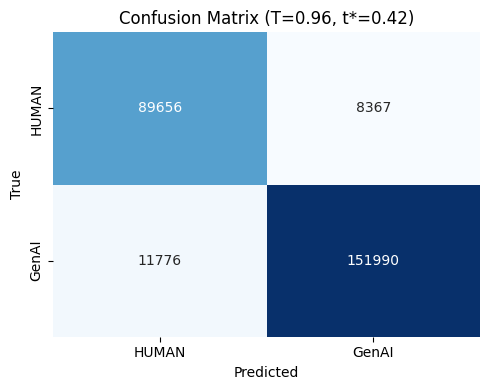


[LOG] Evaluation su VALIDATION — campioni: 261789
Accuracy: 0.9231  |  F1 macro: 0.9184  |  Precision macro: 0.9159  |  Recall macro: 0.9214


In [ ]:
# EVAL_CSV ≡ VALIDATION (resto del DEV)
EVAL_CSV = VAL_CSV
assert os.path.exists(EVAL_CSV)

# recupero vocab (se servisse)
base_vocab = vocab

df_eval = pd.read_csv(EVAL_CSV)
print(f"[LOG] VALIDATION: {EVAL_CSV} ({len(df_eval)} righe)")
print("[LOG] Distribuzione label:"); print(df_eval["label"].value_counts().sort_index().to_string())

rep_eval, cm_eval, n_eval = evaluate_csv(
    model, EVAL_CSV, vocab=base_vocab,
    label_names=("HUMAN","GenAI"),
    temperature=T, threshold=t_star,
    plot_cm=True, title_suffix=f"(T={T:.2f}, t*={t_star:.2f})"
)
assert cm_eval.sum() == n_eval
print(f"\n[LOG] Evaluation su VALIDATION — campioni: {n_eval}")
print(f"Accuracy: {rep_eval['accuracy']:.4f}  |  F1 macro: {rep_eval['macro avg']['f1-score']:.4f}  "
      f"|  Precision macro: {rep_eval['macro avg']['precision']:.4f}  |  Recall macro: {rep_eval['macro avg']['recall']:.4f}")

In [ ]:
# Tabelle e CSV SOLO per il TEST fisso (60)
TEST_EVAL_CSV = TEST_CSV
test_ds_for_table = TextDataset(TEST_EVAL_CSV, vocab=vocab)
test_dl_for_table = DataLoader(
    test_ds_for_table,
    batch_size=global_var["batch_size"],
    num_workers=min(4, global_var["n_workers"]),
    shuffle=False, pin_memory=(device.type=="cuda")
)

probs, preds = [], []
model.eval()
with torch.inference_mode():
    for bx, _ in test_dl_for_table:
        logits = model(bx.to(device)) / T
        p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
        probs.extend(p1.tolist())
        preds.extend((p1 >= t_star).astype(int).tolist())

df_src = pd.read_csv(TEST_EVAL_CSV)
lab = {0: "HUMAN", 1: "GenAI"}
df_out = pd.DataFrame({
    **({"id": df_src["id"]} if "id" in df_src.columns else {}),
    **({"topic": df_src["topic"]} if "topic" in df_src.columns else {}),
    "text": df_src["text"].astype(str),
    "true_id": df_src["label"].astype(int),
    "pred_id": np.array(preds, dtype=int),
    "prob_genai": np.array(probs, dtype=float)
})
df_out["true"] = df_out["true_id"].map(lab)
df_out["pred"] = df_out["pred_id"].map(lab)
df_out["prob_genai_pct"] = (df_out["prob_genai"]*100.0).round(2)
df_out["prob_genai_it"]  = df_out["prob_genai_pct"].map(lambda x: f"{x:.2f}%".replace('.',','))
df_out["correct"] = np.where(df_out["true_id"]==df_out["pred_id"], "✓", "✗")

df_view = df_out.copy()
df_view["err_rank"] = (df_view["correct"]=="✓").astype(int)
df_view = df_view.sort_values(["err_rank","prob_genai"], ascending=[True,False]).drop(columns=["err_rank"])

pd.set_option("display.max_colwidth", 160)
cols = [c for c in ["id","topic"] if c in df_view.columns] + ["text","true","pred","prob_genai_it","correct"]
print("[INFO] Prime 30 righe (errori in alto). Il file completo viene salvato su Drive.\n")
display(df_view[cols].head(30))

fname = f"predictions_TEST_EN_fixed_T{T:.2f}_t{t_star:.2f}.csv"
save_path = os.path.join(BASE, fname)
df_view.to_csv(save_path, index=False, encoding="utf-8")
print("[LOG] File predizioni TEST (60) salvato in:", save_path, "| righe:", len(df_view))

[INFO] Prime 30 righe (errori in alto). Il file completo viene salvato su Drive.



,id,text,true,pred,prob_genai_it,correct
29,ad236fe9-a338-4076-83a5-d43ec5611f74,"The earliest surviving written work on the subject of architecture is De architectura, by the Roman architect Vitruvius in the early 1st century AD. Accordi...",HUMAN,GenAI,"70,18%",✗
40,8ee751b4-46d5-41d7-8053-f916d9a1b839,Tyler decides to pull the ultimate school prank. He gets a group of friends to trash the principles house. While trashing the house someone calls the cops. ...,GenAI,HUMAN,"40,04%",✗
59,f6e53ad7-b2b8-4441-b7c2-d7b942495758,"Cullen and Jay had a bet on a football game. They watched together as Jay's team took the lead. For the entire game, Jay's team dominated. Cullen was expect...",GenAI,HUMAN,"38,88%",✗
13,2e12821f-de4a-49f8-9231-b33f9bbee3d3,"OnlyFans founder and CEO Tim Stokely is stepping down. Ami Gan, the company's former head of communications and marketing, will be taking over as CEO. Gan h...",GenAI,HUMAN,"20,84%",✗
41,9785b35f-4473-4ddc-b09b-a93a24a85369,Jack and Tom were friends for more than fifteen years. They met in college and shared the same interest in politics. They spent countless hours discussing p...,GenAI,HUMAN,"15,84%",✗
31,5ff1a07c-2324-4e5b-90f8-1399b5ecc07c,"Early man’s only dietary choice for millions of years was the cave man diet. Cavemen did not “cook” because there was no protein in their food, they fought ...",GenAI,HUMAN,"8,91%",✗
4,ca011877-685b-418e-9a48-3be3627c6610,throw the grass they cut back behind them. they kick it over the fence.,GenAI,HUMAN,"2,28%",✗
39,957421f3-5b8f-475e-a9a2-ba1bbd78b96b,"ring-ring [ obstacleObject (classification, distance) classification human (s) distance 800m run eSTOP DangerException: Action unsuccessful run emergencyReR...",GenAI,GenAI,"99,48%",✓
27,06e7b288-08df-406c-aa72-421c02fd326b,Sports are one way that many high school students can have fun outside of class while still being involved at their own pace. Students who play sports tend ...,GenAI,GenAI,"98,61%",✓
1,d728821a-914a-463b-8c65-69014dfdbe77,"In this paper, we propose a characterization of chordal bipartite graphs and an efficient enumeration algorithm for chordal bipartite induced subgraphs. A c...",GenAI,GenAI,"98,16%",✓


[LOG] File predizioni TEST (60) salvato in: /content/drive/MyDrive/TESI-Classificazione/MIO/predictions_TEST_EN_fixed_T0.96_t0.42.csv | righe: 60


# Quick prediction

Questo blocco fa due cose principali:

**1) Recupero resiliente del vocabolario (`base_vocab`)**  
Cerca di risalire ricorsivamente gli oggetti tipici di PyTorch (es. `Subset`, `DataLoader` --> `.dataset` --> etc...) finché trova un attributo `vocab`. La funzione `extract_vocab` evita loop con un set di ID già visti. Se il vocab non si trova:
- prova candidati globali probabili (`train_dataset`, `full_train`, `train_loader`);
- usa il `vocab` globale se presente;
- **fallback finale**: lo ricostruisce dal `TRAIN_CSV` (meno ideale, perché può divergere dallo split usato).

**Costo:** tempo $\mathcal{O}(\text{profondità della catena})$, memoria $\mathcal{O}(1)$.

---

**2) Valutazione del classificatore**<br>
Sono fornite due utility:

- `evaluate_loader(model, loader, …)`: valuta su un **DataLoader**. Con logits $z\in\mathbb{R}^{B\times K}$ e temperatura $T>0$:
  $$
  p=\mathrm{softmax}\!\left(\frac{z}{T}\right),\qquad
  p_{i,c}=\frac{e^{z_{i,c}/T}}{\sum_j e^{z_{i,j}/T}}.
  $$
  **Decisione**:
  - *senza soglia*: $\hat y_i=\arg\max_c z_{i,c}$ (multiclasse);  
  - *con soglia* $t$ (binaria, classe 1): $\hat y_i=\mathbf{1}[\,p_{i,1}\ge t\,]$. <br>
  Restituisce **classification report** (precision/recall/F1 per classe e macro) e **confusion matrix**; opzionalmente disegna la **heatmap**.

- `evaluate_csv(model, csv_path, vocab, …)`: costruisce un `TextDataset` dal CSV, crea il `DataLoader` con `make_loader` (=> *dynamic padding*), quindi richiama `evaluate_loader`. Restituisce **report, matrice** e **numero di esempi**.

Infine il blocco carica l’**holdout** (`EVAL_CSV`), logga la distribuzione delle label e valuta il modello riusando **temperatura** `T_eval` e **soglia** `t_eval`, verificando che il numero di esempi visti coincida con la somma degli elementi nella matrice di confusione.

[LOG] Vocab OK (size=574,882).
[LOG] EVAL_HOLDOUT: /content/drive/MyDrive/TESI-Classificazione/MIO/en_val_holdout.csv (261789 righe)
[LOG] Distribuzione label:
label
0     98023
1    163766


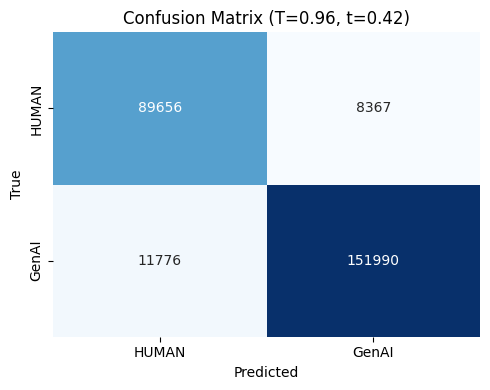


[LOG] Evaluation su holdout — campioni: 261789
Accuracy: 0.9231  |  F1 macro: 0.9184  |  Precision macro: 0.9159  |  Recall macro: 0.9214


In [ ]:
# Se serve, si recupera il vocab da oggetti noti.
def extract_vocab(obj):
    seen = set()                                        #Traccia oggetti già visitati per evitare loop.
    while obj is not None and id(obj) not in seen:      #Risali lungo .dataset finché possibile.
        seen.add(id(obj))
        if hasattr(obj, "vocab"):                       #Se l'oggetto espone un attributo 'vocab' --> trovato.
            return obj.vocab
        obj = getattr(obj, "dataset", None)             #Altrimenti prova a risalire a .dataset (DataLoader/Subset).
    return None                                         #Fallback se non trovato.

base_vocab = None
#Si provano candidati globali più probabili (train_dataset --> full_train --> train_loader).
for cand in [globals().get("train_dataset"), globals().get("full_train"), globals().get("train_loader")]:
    if cand is not None:
        base_vocab = extract_vocab(cand)                #Tenta estrazione ricorsiva del vocab.
        if base_vocab is not None: break                #Stop appena trovato.
#Se ancora None, si prova il vocab globale.
if base_vocab is None and "vocab" in globals():
    base_vocab = vocab
#Ultimo fallback: si ricostruisce dal CSV di train (meno ideale ma robusto).
if base_vocab is None:
    base_vocab = TextDataset(TRAIN_CSV).vocab
print(f"[LOG] Vocab OK (size={len(base_vocab):,}).")

def evaluate_loader(model, loader, label_names=("HUMAN","GenAI"),
                    temperature=1.0, threshold=None, plot_cm=False, title_suffix=""):
    model.eval()                                              #Modalità eval (niente dropout/bn).
    y_true, y_pred = [], []
    with torch.inference_mode():                              #Disabilita grad per velocità/memoria.
        for bx, by in loader:
            logits = model(bx.to(device)) / temperature       #Logits scalati con T.
            if threshold is None:                         #Caso 1: decisione argmax (multiclasse).
                pred = logits.argmax(1).cpu().numpy()
            else:                                         #Caso 2: soglia binaria sulla probabilità della classe 1.
                p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
                pred = (p1 >= threshold).astype(int)
            y_pred.extend(pred); y_true.extend(by.cpu().numpy())

    labels_fixed = [0, 1]                                     #Ordine etichette fisso per report/CM.
    report = classification_report(                           #Report strutturato (dict) con metriche per classe e macro.
        y_true, y_pred, labels=labels_fixed,
        target_names=list(label_names),
        output_dict=True, digits=4, zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred, labels=labels_fixed)      #Matrice di confusione.

    if plot_cm:                                         #Visualizzazione opzionale della CM.
        plt.figure(figsize=(5,4))
        tick_labels = [label_names[i] for i in labels_fixed]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=tick_labels, yticklabels=tick_labels, cbar=False)
        ttl = "Confusion Matrix" + (f" {title_suffix}" if title_suffix else "")
        plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(ttl)
        plt.tight_layout(); plt.show()

    return report, cm                                   #Ritorna metriche e CM.

def evaluate_csv(model, csv_path, vocab, batch_size=None, n_workers=None,
                 label_names=("HUMAN","GenAI"), temperature=1.0, threshold=None,
                 plot_cm=False, title_suffix=""):
    batch_size = batch_size or global_var["batch_size"]           #Batch di default da config globale.
    ds = TextDataset(csv_path, vocab=vocab)                       #Dataset dal CSV, forzando il vocab di train.
    dl = make_loader(ds, batch_size=batch_size, shuffle=False)    #DataLoader con dynamic padding.
    rep, cm = evaluate_loader(                                    #Valuta sul loader.
        model, dl, label_names=label_names,
        temperature=temperature, threshold=threshold,
        plot_cm=plot_cm, title_suffix=title_suffix
    )
    return rep, cm, len(ds)                                       #Restituisce anche il numero di esempi.

# VERIFICHE E LOG SULL'HOLDOUT:
assert os.path.exists(EVAL_CSV), f"File non trovato: {EVAL_CSV}"
df_eval = pd.read_csv(EVAL_CSV)
print(f"[LOG] EVAL_HOLDOUT: {EVAL_CSV} ({len(df_eval)} righe)")
print("[LOG] Distribuzione label:")
print(df_eval["label"].value_counts().sort_index().to_string())

#Riuso della temperatura e della soglia ottimali trovate su validation.
T_eval = T
t_eval = t_star

# VALUTAZIONE SU CSV DI HOLDOUT CON T_eval E t_eval (e heatmap ConfusionMatrix):
rep_eval, cm_eval, n_eval = evaluate_csv(
    model, EVAL_CSV, vocab=vocab,
    label_names=("HUMAN","GenAI"),
    temperature=T_eval, threshold=t_eval,
    plot_cm=True, title_suffix=f"(T={T_eval:.2f}, t={t_eval:.2f})"
)

# SANITY CHECK; LA SOMMA DELLA ConfusioMatrix DEVE EGUAGLIARE IL NUMERO DI ESEMPI:
assert cm_eval.sum() == n_eval, f"Non ho visto tutto l'EVAL: visti {cm_eval.sum()} su {n_eval}"
print(f"\n[LOG] Evaluation su holdout — campioni: {n_eval}")
print(f"Accuracy: {rep_eval['accuracy']:.4f}  |  F1 macro: {rep_eval['macro avg']['f1-score']:.4f}  "
      f"|  Precision macro: {rep_eval['macro avg']['precision']:.4f}  |  Recall macro: {rep_eval['macro avg']['recall']:.4f}")

Questo blocco costruisce un **tabellone di evaluation**: legge l’`EVAL_CSV`, esegue **inference** con *temperature scaling* $T_{\text{eval}}$ e **soglia** $t_{\text{eval}}$, aggrega **probabilità**, **predizioni** e **etichette vere**, e produce una **tabella ordinata** (errori in alto) oltre a salvare un CSV completo su Drive.

- **Caricamento eval & coerenza vocabolario.**  
  `TextDataset(EVAL_CSV, vocab=vocab)` forza l’uso del **vocabolario del train**, garantendo coerenza degli ID (stessa token→ID mapping della fase di addestramento).

- **Inference (batch).**  
  Per ogni batch si calcola:
  $$
  p_{1}=\left(\mathrm{softmax}\!\left(\frac{z}{T_{\text{eval}}}\right)\right)_{c=1},
  \qquad
  \hat y=\mathbf{1}\!\left[p_{1}\ge t_{\text{eval}}\right],
  $$
  dove $p_{1}$ è la probabilità della classe **GenAI**. Le probabilità sono raccolte in `probs` e le predizioni binarie in `preds`.

- **Costruzione tabella.**  
  Si crea un `DataFrame` con colonne testuali (`id`, `topic`, `text`) e numeriche (`true_id`, `pred_id`, `prob_genai`), si mappano gli ID a stringhe (*HUMAN/GenAI*) e si aggiunge il flag di correttezza **✓/✗**.

- **Ordinamento (errori in alto).**  
  Si introduce un ranking temporaneo (`err_rank`) per **mettere in testa gli errori**, e a parità di correttezza si ordina per **probabilità GenAI** decrescente (per ispezionare i casi più “convinti”).

- **Visualizzazione & salvataggio.**  
  Vengono mostrate a schermo le **prime 30 righe** e si salva **l’intera tabella** in un CSV versionato con $T_{\text{eval}}$ e $t_{\text{eval}}$ nel nome file. Un secondo riquadro mostra **solo gli errori** per un debug rapido.

In [ ]:
# TABELLA PREDIZIONI DETTAGLIATE:
eval_ds = TextDataset(EVAL_CSV, vocab=vocab)                     #Dataset eval con VOCAB del train (coerenza ID).
eval_dl = DataLoader(                                            #DataLoader batchato per inference.
    eval_ds,
    batch_size=global_var["batch_size"],
    num_workers=min(4, global_var["n_workers"]),
    shuffle=False,                                               #Niente shuffle in evaluation.
    pin_memory=(device.type=="cuda")                             #Pin per DMA più rapido su GPU.
)

probs, preds = [], []                                            #Liste per probabilità (classe 1) e predizioni binarie.
model.eval()                                                     #Modalità eval (no dropout/bn).
with torch.inference_mode():                                     #Niente grad --> meno memoria/più velocità.
    for bx, _ in eval_dl:
        logits = model(bx.to(device)) / T_eval                   #Logits scalati con temperatura T_eval.
        p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()        #Probabilità classe GenAI (indice 1).
        probs.extend(p1.tolist())                                #Accumula probabilità.
        preds.extend((p1 >= t_eval).astype(int).tolist())        #Predizione binaria con soglia t_eval.

df_src = pd.read_csv(EVAL_CSV)                                              #Carica CSV sorgente per colonne testuali/meta.
map_lab = {0: "HUMAN", 1: "GenAI"}                                          #Mapping ID-->nome classe.
df_out = pd.DataFrame({                                                     #Costruisce tabella “grezza” di output.
    **({"id": df_src["id"]} if "id" in df_src.columns else {}),             #Include 'id' se presente.
    **({"topic": df_src["topic"]} if "topic" in df_src.columns else {}),    #Include 'topic' se presente.
    "text": df_src["text"].astype(str),                                     #Testo originale.
    "true_id": df_src["label"].astype(int),                                 #Etichetta reale numerica.
    "pred_id": np.array(preds, dtype=int),                                  #Predizione numerica (0/1).
    "prob_genai": np.array(probs, dtype=float)                              #Probabilità continua classe GenAI.
})
df_out["true"] = df_out["true_id"].map(map_lab)                                   #Etichetta reale come stringa.
df_out["pred"] = df_out["pred_id"].map(map_lab)                                   #Etichetta predetta come stringa.
df_out["correct"] = np.where(df_out["true_id"] == df_out["pred_id"], "✓", "✗")    #Flag correttezza.

# ORDINA GLI ERRORI PRIMA, POI LA PROBABILITA' GenAI DECRESCENTE (ispezione prioritaria).
df_view = df_out.copy()
df_view["err_rank"] = (df_view["correct"] == "✓").astype(int)          #0=errore, 1=corretto.
df_view = df_view.sort_values(
    ["err_rank","prob_genai"], ascending=[True, False]
).drop(columns=["err_rank"])

# VISUALIZZAZIONE DELL'ANTEPRIMA (prime 30 righe):
pd.set_option("display.max_colwidth", 160)                              #Colonna testo più larga per lettura.
display_cols = [c for c in ["id","topic"] if c in df_view.columns] \
             + ["text","true","pred","prob_genai","correct"]
print(f"[INFO] Mostro le prime 30 righe (errori in alto). Il file completo viene salvato su Drive.\n")
display(df_view[display_cols].head(30))

# SALVATAGGIO CSV; VERSIONE CON T E t NEL NOME (tracciabilità dell’esperimento):
fname = f"eval_predictions_EN_T{T_eval:.2f}_t{t_eval:.2f}.csv"
save_path = os.path.join(BASE, fname)
df_view.to_csv(save_path, index=False, encoding="utf-8")
print("[LOG] File completo salvato in:", save_path)

# RIQUADRO “SOLO ERRORI”; UTILE PER ANALISI MIRATA DEI FALSI POSITIVI/NEGATIVI:
df_errors = df_view[df_view["correct"]=="✗"][display_cols]
print(f"\n[INFO] Errori totali: {len(df_errors)}\n")
display(df_errors.head(20))

[INFO] Mostro le prime 30 righe (errori in alto). Il file completo viene salvato su Drive.



,id,text,true,pred,prob_genai,correct
56099,9daee63d-3f19-46e4-9e21-704fa9a0cbff,Pars goalkeeper Sean Murdoch denied Jamie Adams in a first half of few chances before two quick fire goals put the visitors in control. El Bakhtaoui raced o...,HUMAN,GenAI,0.996340,✗
109563,559024d1-c219-4be8-b84c-b9aec7245662,Police said the man was being held over alleged offensive behaviour. He is understood to be among those pictured in a recent police CCTV images appeal. Seve...,HUMAN,GenAI,0.994605,✗
63347,395ae1e2-d43d-4772-906e-17ddbbf55313,I had a great experience with the service department. Andy was my service advisor and I highly recommend him. Everyone says dealership charges too much for ...,HUMAN,GenAI,0.992990,✗
14120,9deaa3fa-c0bb-4083-8fb7-ad9f61906b9c,"Elizabeth Holmes, the former chief executive of biotech startup Theranos, was found guilty on four of 11 charges of defrauding the company's investors and n...",HUMAN,GenAI,0.992553,✗
42193,ac641748-06af-4bdb-a577-65e563fcfe6b,"In the situation you describe, I would strongly consider purchasing. Before purchasing, I would do the following: Think about your goals. Work with good pe...",HUMAN,GenAI,0.991888,✗
11561,441ca1eb-524c-4e04-9ba8-6d57a88638f6,We propose a novel reliability model for composing energy service requests. The proposed model is based on consumers' behavior and history of energy request...,HUMAN,GenAI,0.991753,✗
27065,94447790-9a2e-4ea7-8301-c6d768293ee6,"I've been eating pizza my whole life. I'm Italian from NY, and have spent time in Chicago. So I know what Chicago pizza is supposed to be..... Not this. Not...",HUMAN,GenAI,0.991575,✗
40107,3805865d-8cc2-4f00-b26f-3f2d01dd2dae,As soon as deer season opened I was in the stand. All around me the woods were waking up with wildlife. It was such a beautiful sight to see the sunset cres...,HUMAN,GenAI,0.990303,✗
134424,724e85ac-a169-4ae7-8e38-a34e28cec1f4,It was great Korean food! Lunch prices were good. PS6-8 per pate. Great appetisers and best of all EVERYONE LOVED what they got! And I went with a tough gro...,HUMAN,GenAI,0.990113,✗
15132,c1d1bfbd-c3b0-48fb-b52f-1977369d1de9,I think I saw a video that explained what being autistic was like . It seems as though over stimulus is really hard for someone with autism to deal with whi...,HUMAN,GenAI,0.990087,✗


[LOG] File completo salvato in: /content/drive/MyDrive/TESI-Classificazione/MIO/eval_predictions_EN_T0.96_t0.42.csv

[INFO] Errori totali: 20144



,id,text,true,pred,prob_genai,correct
56099,9daee63d-3f19-46e4-9e21-704fa9a0cbff,Pars goalkeeper Sean Murdoch denied Jamie Adams in a first half of few chances before two quick fire goals put the visitors in control. El Bakhtaoui raced o...,HUMAN,GenAI,0.996340,✗
109563,559024d1-c219-4be8-b84c-b9aec7245662,Police said the man was being held over alleged offensive behaviour. He is understood to be among those pictured in a recent police CCTV images appeal. Seve...,HUMAN,GenAI,0.994605,✗
63347,395ae1e2-d43d-4772-906e-17ddbbf55313,I had a great experience with the service department. Andy was my service advisor and I highly recommend him. Everyone says dealership charges too much for ...,HUMAN,GenAI,0.992990,✗
14120,9deaa3fa-c0bb-4083-8fb7-ad9f61906b9c,"Elizabeth Holmes, the former chief executive of biotech startup Theranos, was found guilty on four of 11 charges of defrauding the company's investors and n...",HUMAN,GenAI,0.992553,✗
42193,ac641748-06af-4bdb-a577-65e563fcfe6b,"In the situation you describe, I would strongly consider purchasing. Before purchasing, I would do the following: Think about your goals. Work with good pe...",HUMAN,GenAI,0.991888,✗
11561,441ca1eb-524c-4e04-9ba8-6d57a88638f6,We propose a novel reliability model for composing energy service requests. The proposed model is based on consumers' behavior and history of energy request...,HUMAN,GenAI,0.991753,✗
27065,94447790-9a2e-4ea7-8301-c6d768293ee6,"I've been eating pizza my whole life. I'm Italian from NY, and have spent time in Chicago. So I know what Chicago pizza is supposed to be..... Not this. Not...",HUMAN,GenAI,0.991575,✗
40107,3805865d-8cc2-4f00-b26f-3f2d01dd2dae,As soon as deer season opened I was in the stand. All around me the woods were waking up with wildlife. It was such a beautiful sight to see the sunset cres...,HUMAN,GenAI,0.990303,✗
134424,724e85ac-a169-4ae7-8e38-a34e28cec1f4,It was great Korean food! Lunch prices were good. PS6-8 per pate. Great appetisers and best of all EVERYONE LOVED what they got! And I went with a tough gro...,HUMAN,GenAI,0.990113,✗
15132,c1d1bfbd-c3b0-48fb-b52f-1977369d1de9,I think I saw a video that explained what being autistic was like . It seems as though over stimulus is really hard for someone with autism to deal with whi...,HUMAN,GenAI,0.990087,✗
